In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/Colab Notebooks

/content/drive/My Drive/Colab Notebooks


In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

The general parameters for our task are the future horizon of our prediction and the hyperparameter for the network

In [4]:
prediction_days = 30
nof_units = 4

We will encapsulate our model creation step in a function. It will accept a single parameter, units, which is the dimension of the innter cells in LSTM

In [5]:
def create_model(nunits):

    # Initialising the RNN
    regressor = Sequential()

    # Adding the input layer and the LSTM layer
    regressor.add(LSTM(units = nunits, activation = 'sigmoid', input_shape = (None, 1)))

    # Adding the output layer
    regressor.add(Dense(units = 1))

    # Compiling the RNN
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
    
    return regressor

In [6]:
# load the data and encode the date
df = pd.read_csv("bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")
df['date'] = pd.to_datetime(df['Timestamp'],unit='s').dt.date
group = df.groupby('date')
Real_Price = group['Weighted_Price'].mean()
# We will predict the average daily price that is why we need to group the date

In [7]:
# The next step will be splitting the data into training and testing dataset
df_train= Real_Price[:len(Real_Price)-prediction_days] # This will start the dataset at 0 until len(Real_price)-prediction_days
df_test= Real_Price[len(Real_Price)-prediction_days:] # This will start the dataset at  len(Real_price)-prediction_days until the end

In [8]:
# Perform preprocessing
training_set = df_train.values
training_set = np.reshape(training_set, (len(training_set), 1))

sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]  # training set
y_train = training_set[1:len(training_set)] # testing dataset
X_train = np.reshape(X_train, (len(X_train), 1, 1))

In [9]:
# Fit the model

# Initialising the RNN
regressor = create_model(nunits = 4)
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 5, epochs = 100) # We will run for a 100 times

Epoch 1/100
669/669 [==============================] - 3s 2ms/step - loss: 0.0171
Epoch 2/100
669/669 [==============================] - 1s 2ms/step - loss: 0.0085
Epoch 3/100
669/669 [==============================] - 1s 2ms/step - loss: 0.0057
Epoch 4/100
669/669 [==============================] - 2s 3ms/step - loss: 0.0033
Epoch 5/100
669/669 [==============================] - 2s 3ms/step - loss: 0.0015
Epoch 6/100
669/669 [==============================] - 1s 2ms/step - loss: 4.8516e-04
Epoch 7/100
669/669 [==============================] - 1s 2ms/step - loss: 1.4963e-04
Epoch 8/100
669/669 [==============================] - 1s 2ms/step - loss: 8.5156e-05
Epoch 9/100
669/669 [==============================] - 1s 2ms/step - loss: 7.5806e-05
Epoch 10/100
669/669 [==============================] - 1s 2ms/step - loss: 7.2304e-05
Epoch 11/100
669/669 [==============================] - 1s 2ms/step - loss: 6.7086e-05
Epoch 12/100
669/669 [==============================] - 1s 2ms/step - lo

As can be seen from the above result, once the number of epochs are increased, the loss is decreased. That means the model is learning good with high accuracy.

With a fitted model we can generate a predition over the forecast horizon, keeping in mind that we need to invert our normalization so that the values are back on the original scale

In [10]:
test_set = df_test.values
inputs = np.reshape(test_set, (len(test_set), 1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))
predicted_BTC_price = regressor.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)

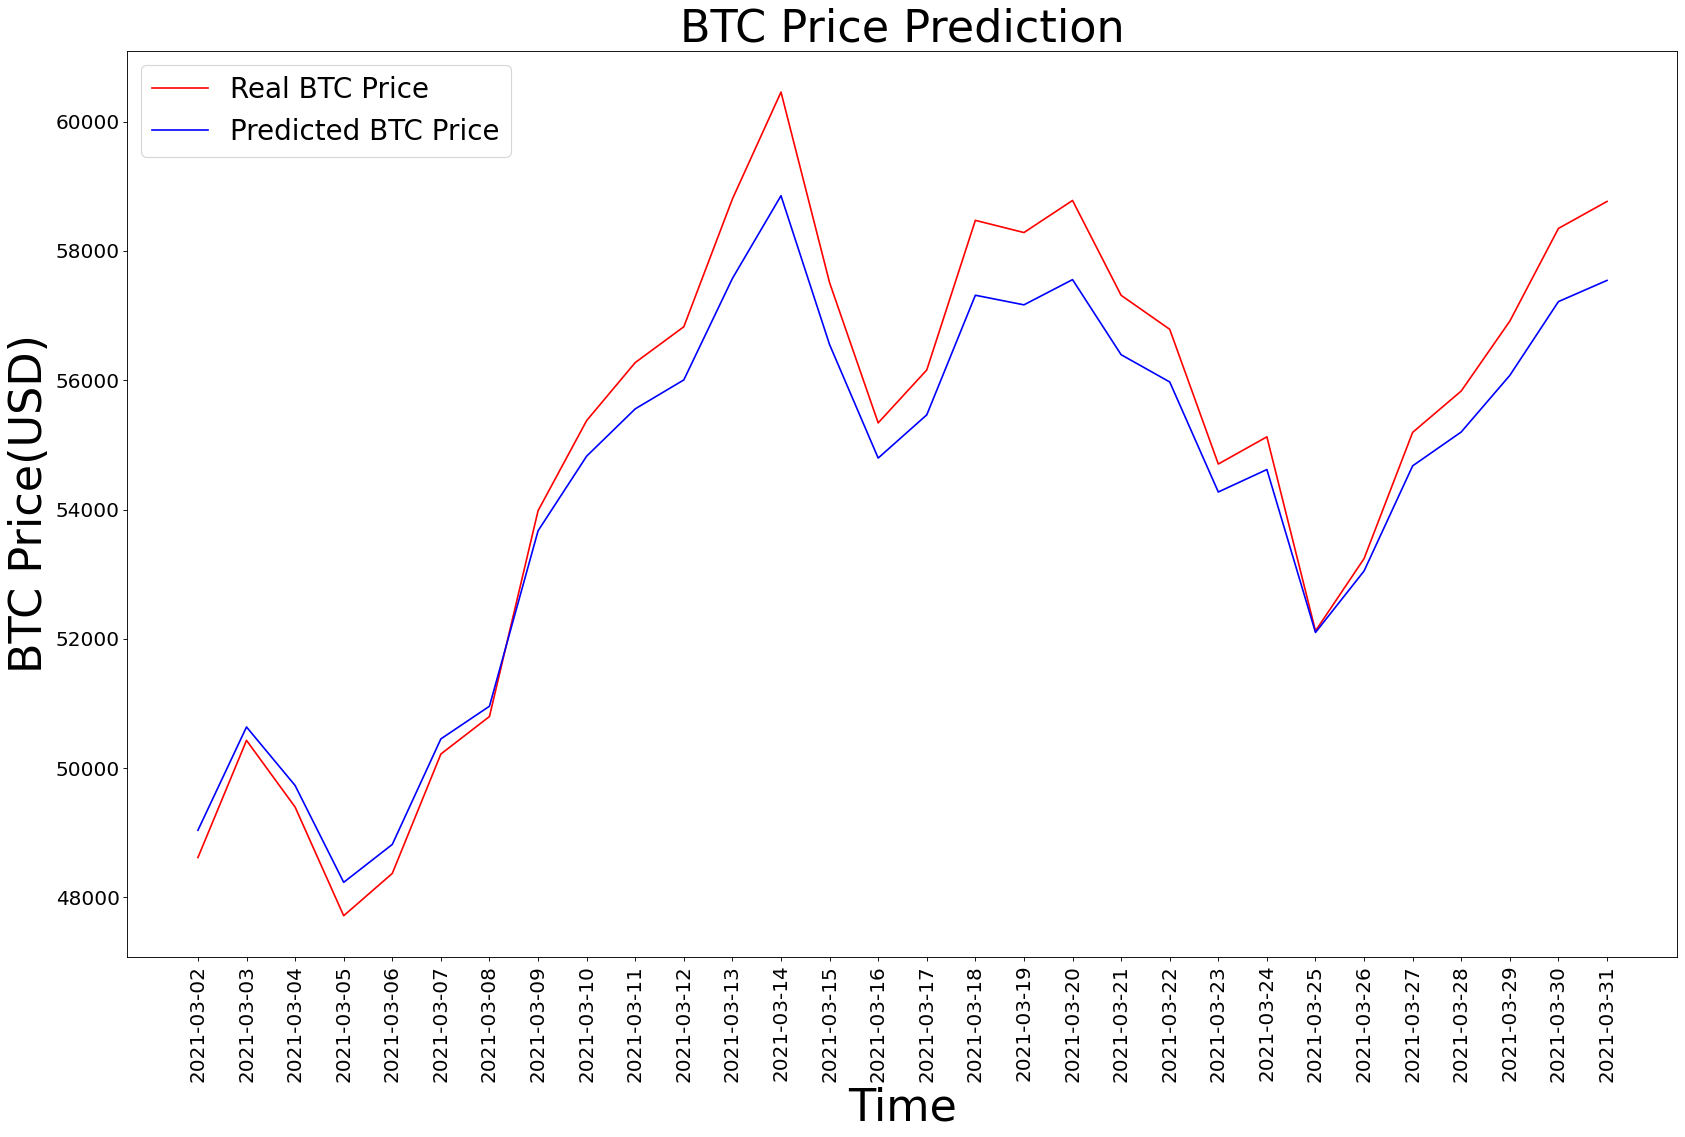

In [11]:
# Plotting the forecasted results
plt.figure(figsize=(25,15), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()  
plt.plot(test_set, color = 'red', label = 'Real BTC Price')
plt.plot(predicted_BTC_price, color = 'blue', label = 'Predicted BTC Price')
plt.title('BTC Price Prediction', fontsize=40)
df_test = df_test.reset_index()
x=df_test.index
labels = df_test['date']
plt.xticks(x, labels, rotation = 'vertical')
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD)', fontsize=40)
plt.legend(loc=2, prop={'size': 25})
plt.show()

As can be seen from the above result, our simple model can generate a reasonable prediction with an important caveat: This approach only works as long as the environment is stationary that is the nature of the relationship between past and present values reamins stable over time. Regime changes and sudden interventions will have a significant impact on the price. For example,  a major jurisdiction were to restrict the usage of crytocurrencies. We can model such occurence but it require more elaborate approach to feature engineering.